In [70]:
# Just used to adjust the way the notebook is displayed
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [71]:
import pandas as pd
import numpy as np 

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

In [72]:
sns.set_theme(style="darkgrid", palette="Set2", context="talk") # Set style for future visualizations 

In [73]:
df = pd.read_csv('archive/heart_2020_cleaned.csv') 
df

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,Yes,27.41,Yes,No,No,7.0,0.0,Yes,Male,60-64,Hispanic,Yes,No,Fair,6.0,Yes,No,No
319791,No,29.84,Yes,No,No,0.0,0.0,No,Male,35-39,Hispanic,No,Yes,Very good,5.0,Yes,No,No
319792,No,24.24,No,No,No,0.0,0.0,No,Female,45-49,Hispanic,No,Yes,Good,6.0,No,No,No
319793,No,32.81,No,No,No,0.0,0.0,No,Female,25-29,Hispanic,No,No,Good,12.0,No,No,No


In [74]:
# Function to convert 'yes' 'no' and 'male' 'female' to '1' and '0'
def binary_converter(row):
    if row == 'Yes':
        return 1
    if row == 'No':
        return 0 
    if row == 'Male':
        return 1
    if row == 'Female':
        return 0 

In [75]:
# Identifies binary columns and converts their values to 1 and 0 using the binary_converter function
binary_col_list = []
for col in df.columns:
    if len(pd.unique(df[col])) == 2:
        binary_col_list.append(df[col].apply(binary_converter))

In [76]:
binary_df = pd.concat(binary_col_list, axis=1) # Makes dataframe from binary column list
# Takes the categorical columns of the dataset and makes dummy variables
dummy_df = pd.get_dummies(df[['AgeCategory','Race','Diabetic','GenHealth']]) 
# Concatenates the two dataframes we just made with the columns that cannot be processed during this step
processed_df = pd.concat([binary_df, dummy_df, df[['BMI','PhysicalHealth','MentalHealth','SleepTime']]], axis=1)
processed_df # Now every column is binary except for the numerical ones

,HeartDisease,Smoking,AlcoholDrinking,Stroke,DiffWalking,Sex,PhysicalActivity,Asthma,KidneyDisease,SkinCancer,...,Diabetic_Yes (during pregnancy),GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,BMI,PhysicalHealth,MentalHealth,SleepTime
0,0,1,0,0,0,0,1,1,0,1,...,0,0,0,0,0,1,16.60,3.0,30.0,5.0
1,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,1,20.34,0.0,0.0,7.0
2,0,1,0,0,0,1,1,1,0,0,...,0,0,1,0,0,0,26.58,20.0,30.0,8.0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,24.21,0.0,0.0,6.0
4,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,1,23.71,28.0,0.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,1,1,0,0,1,1,0,1,0,0,...,0,0,1,0,0,0,27.41,7.0,0.0,6.0
319791,0,1,0,0,0,1,1,1,0,0,...,0,0,0,0,0,1,29.84,0.0,0.0,5.0
319792,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,24.24,0.0,0.0,6.0
319793,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,32.81,0.0,0.0,12.0


In [77]:
y = processed_df['HeartDisease']
X = processed_df.drop('HeartDisease',axis=1)
features = X.columns

In [78]:
# Splitting the data into train and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [79]:
X_train

,Smoking,AlcoholDrinking,Stroke,DiffWalking,Sex,PhysicalActivity,Asthma,KidneyDisease,SkinCancer,AgeCategory_18-24,...,Diabetic_Yes (during pregnancy),GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,BMI,PhysicalHealth,MentalHealth,SleepTime
33272,1,1,0,0,0,1,0,0,1,0,...,0,1,0,0,0,0,19.53,0.0,0.0,9.0
160531,1,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,47.26,2.0,30.0,5.0
17642,1,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,26.43,0.0,0.0,5.0
38673,0,0,0,1,0,1,1,0,1,0,...,0,0,1,0,0,0,36.90,20.0,30.0,8.0
150955,1,0,0,0,1,1,1,0,0,0,...,0,0,0,1,0,0,33.38,0.0,20.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122579,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,27.32,0.0,0.0,8.0
304137,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,25.61,0.0,0.0,10.0
152315,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,1,35.44,0.0,0.0,8.0
117952,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,35.04,8.0,8.0,7.0


In [80]:
X_test

,Smoking,AlcoholDrinking,Stroke,DiffWalking,Sex,PhysicalActivity,Asthma,KidneyDisease,SkinCancer,AgeCategory_18-24,...,Diabetic_Yes (during pregnancy),GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,BMI,PhysicalHealth,MentalHealth,SleepTime
126167,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,23.44,10.0,20.0,6.0
207506,0,0,0,0,1,1,0,0,0,0,...,0,1,0,0,0,0,32.49,0.0,4.0,8.0
274544,0,0,0,0,1,1,0,0,0,0,...,0,1,0,0,0,0,21.93,0.0,0.0,7.0
121049,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,1,26.58,0.0,2.0,7.0
260961,1,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,19.02,2.0,2.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294743,1,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,34.67,0.0,0.0,6.0
106981,1,0,0,0,1,1,0,0,0,0,...,0,1,0,0,0,0,20.98,0.0,0.0,6.0
208699,1,0,0,0,1,1,0,0,0,1,...,0,1,0,0,0,0,38.27,0.0,0.0,8.0
235427,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,25.42,0.0,0.0,8.0


In [81]:
# Now that our data is split into train and test, we apply standard scaling to the numerical columns
scaler = StandardScaler()
scaled_numerical_cols_train = scaler.fit_transform(X_train[['BMI','PhysicalHealth','MentalHealth','SleepTime']])
scaled_numerical_df_train = pd.DataFrame(scaled_numerical_cols_train, columns=['BMI','PhysicalHealth','MentalHealth','SleepTime'])

scaled_numerical_cols_test = scaler.transform(X_test[['BMI','PhysicalHealth','MentalHealth','SleepTime']])
scaled_numerical_df_test = pd.DataFrame(scaled_numerical_cols_test, columns=['BMI','PhysicalHealth','MentalHealth','SleepTime'])

In [82]:
# Replace original data with scaled versions
for col in scaled_numerical_df_train.columns:
    X_train[col] = scaled_numerical_df_train[col].values

In [83]:
X_train

,Smoking,AlcoholDrinking,Stroke,DiffWalking,Sex,PhysicalActivity,Asthma,KidneyDisease,SkinCancer,AgeCategory_18-24,...,Diabetic_Yes (during pregnancy),GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,BMI,PhysicalHealth,MentalHealth,SleepTime
33272,1,1,0,0,0,1,0,0,1,0,...,0,1,0,0,0,0,-1.381624,-0.424231,-0.490349,1.322435
160531,1,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,2.977889,-0.172565,3.276966,-1.458969
17642,1,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,-0.296855,-0.424231,-0.490349,-1.458969
38673,0,0,0,1,0,1,1,0,1,0,...,0,0,1,0,0,0,1.349164,2.092426,3.276966,0.627084
150955,1,0,0,0,1,1,1,0,0,0,...,0,0,0,1,0,0,0.795774,-0.424231,2.021194,2.017786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122579,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,-0.156935,-0.424231,-0.490349,0.627084
304137,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,-0.425769,-0.424231,-0.490349,2.017786
152315,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,1,1.119633,-0.424231,-0.490349,0.627084
117952,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,1.056748,0.582432,0.514269,-0.068267


In [84]:
# Replace original data with scaled versions
for col in scaled_numerical_df_test.columns:
    X_test[col] = scaled_numerical_df_test[col].values

In [85]:
X_test

,Smoking,AlcoholDrinking,Stroke,DiffWalking,Sex,PhysicalActivity,Asthma,KidneyDisease,SkinCancer,AgeCategory_18-24,...,Diabetic_Yes (during pregnancy),GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,BMI,PhysicalHealth,MentalHealth,SleepTime
126167,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,-0.766921,0.834098,2.021194,-0.763618
207506,0,0,0,0,1,1,0,0,0,0,...,0,1,0,0,0,0,0.655855,-0.424231,0.011960,0.627084
274544,0,0,0,0,1,1,0,0,0,0,...,0,1,0,0,0,0,-1.004313,-0.424231,-0.490349,-0.068267
121049,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,1,-0.273273,-0.424231,-0.239194,-0.068267
260961,1,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,-1.461802,-0.172565,-0.239194,-0.763618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294743,1,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0.998579,-0.424231,-0.490349,-0.763618
106981,1,0,0,0,1,1,0,0,0,0,...,0,1,0,0,0,0,-1.153665,-0.424231,-0.490349,-0.763618
208699,1,0,0,0,1,1,0,0,0,1,...,0,1,0,0,0,0,1.564545,-0.424231,-0.490349,0.627084
235427,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,-0.455640,-0.424231,-0.490349,0.627084


## Logistic Regression

In [86]:
log_clf = LogisticRegression(max_iter=200).fit(X_train, y_train)

In [87]:
y_pred = log_clf.predict(X_test)
y_pred_proba = log_clf.predict_proba(X_test)

In [88]:
print('accuracy score: ', metrics.accuracy_score(y_test, y_pred))
print('f1 score: ', metrics.f1_score(y_test, y_pred))
print('recall score: ', metrics.recall_score(y_test, y_pred))
print('precision score: ', metrics.precision_score(y_test, y_pred))
print('AUC score: ', metrics.roc_auc_score(y_test, y_pred_proba[:, 1]))
print('confusion matrix :\n ', metrics.confusion_matrix(y_test, y_pred))

accuracy score:  0.9158523429071749
f1 score:  0.17123498614105329
recall score:  0.10207453644207821
precision score:  0.5310410697230181
AUC score:  0.8383787914579347
confusion matrix :
  [[58021   491]
 [ 4891   556]]


In [89]:
# Create dataframe of feature and coefficient values 
coef_list = list(zip(features, log_clf.coef_[0]))
coef_df = pd.DataFrame(coef_list, columns=['Feature', 'Coefficient']).sort_values('Coefficient')

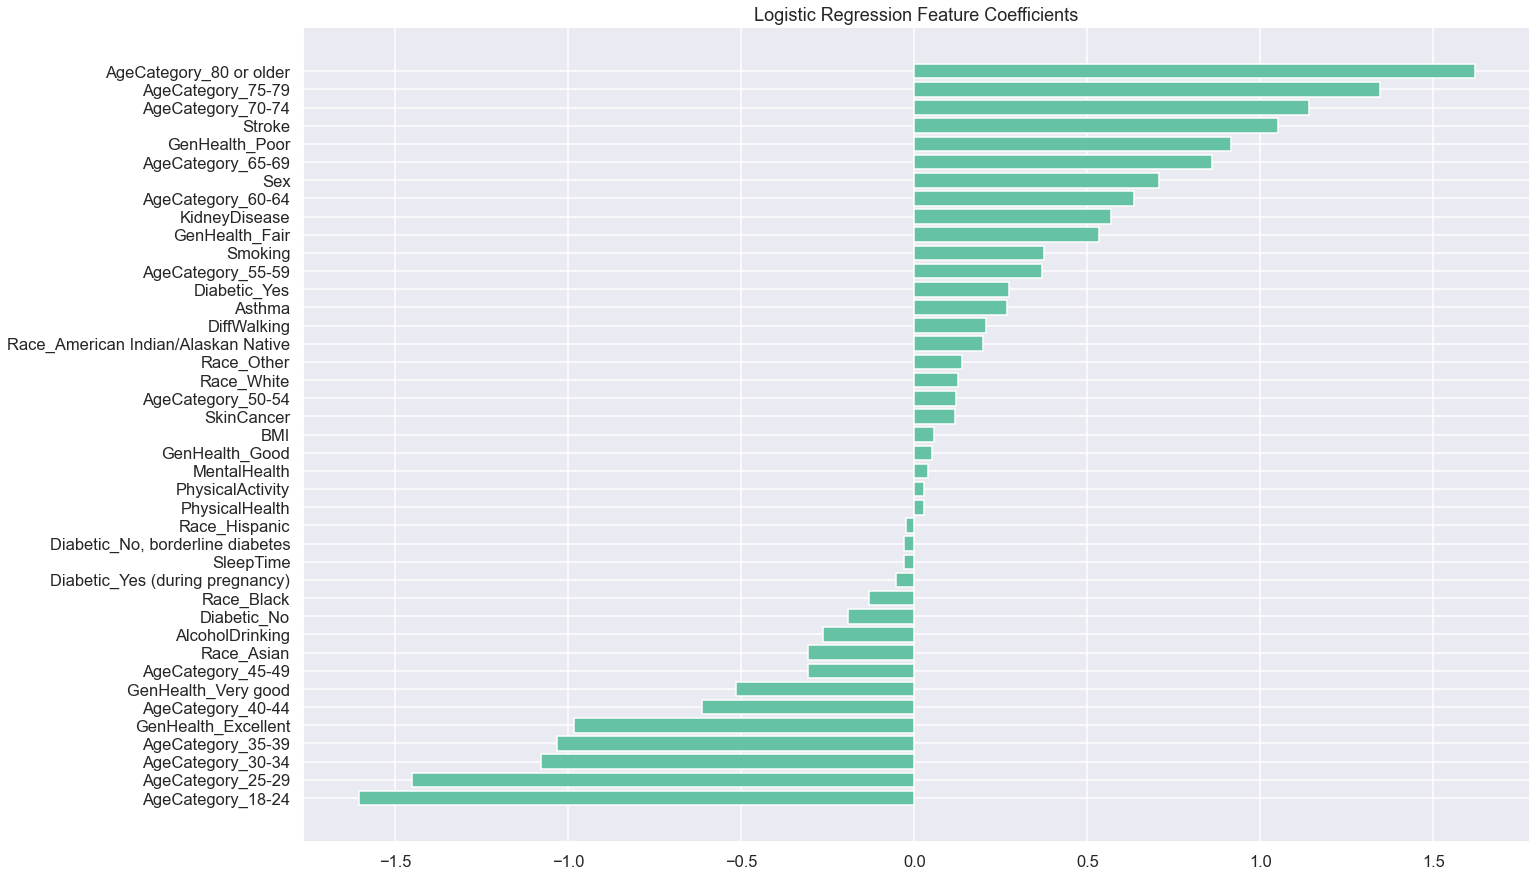

In [90]:
plt.barh(coef_df['Feature'], coef_df['Coefficient'])
plt.title('Logistic Regression Feature Coefficients')
plt.gcf().set_size_inches(22, 15)
plt.show()

## Random Forest

In [91]:
# Test random forest classifiers with different estimators ranging from 10 to 450 
scores = []
for n in range(10,451,10):
    rfc = RandomForestClassifier(n_jobs=-1, n_estimators=n, random_state=0).fit(X_train,y_train)
    y_rfc_pred_proba = rfc.predict_proba(X_test)
    scores.append((n, metrics.roc_auc_score(y_test, y_rfc_pred_proba[:, 1])))

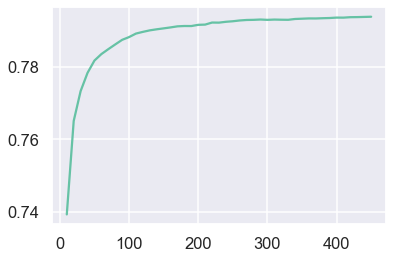

In [92]:
# Plot AUC score for each amount of estimators
plt.plot(*zip(*scores))

In [93]:
# Train using the number of estimators that produced the best AUC score
rfc_opt_n = sorted(scores, key = lambda x: x[1] , reverse=True)[0][0]
rfc = RandomForestClassifier(n_jobs=-1, n_estimators=rfc_opt_n).fit(X_train,y_train)

In [94]:
y_rfc_pred = rfc.predict(X_test)
y_rfc_pred_proba = rfc.predict_proba(X_test)

In [95]:
print('accuracy_score: ', metrics.accuracy_score(y_test, y_rfc_pred))
print('f1_score: ', metrics.f1_score(y_test, y_rfc_pred))
print('recall_score: ', metrics.recall_score(y_test, y_rfc_pred))
print('precision_score: ', metrics.precision_score(y_test, y_rfc_pred))
print('AUC score: ', metrics.roc_auc_score(y_test, y_rfc_pred_proba[:, 1]))
print('confusion_matrix :\n ', metrics.confusion_matrix(y_test, y_rfc_pred))

accuracy_score:  0.9053612470488906
f1_score:  0.17858596824535214
recall_score:  0.12080044060950983
precision_score:  0.34235171696149846
AUC score:  0.7939719890189998
confusion_matrix :
  [[57248  1264]
 [ 4789   658]]


## XGBoost

In [96]:
xbgc = xgb.XGBClassifier(eval_metric='auc', use_label_encoder=False).fit(X_train, y_train)

In [97]:
y_xbgc_pred = xbgc.predict(X_test)
y_xbgc_pred_proba = xbgc.predict_proba(X_test)

In [98]:
print('accuracy score: ', metrics.accuracy_score(y_test, y_xbgc_pred))
print('f1 score: ', metrics.f1_score(y_test, y_xbgc_pred))
print('recall score: ', metrics.recall_score(y_test, y_xbgc_pred))
print('precision score: ', metrics.precision_score(y_test, y_xbgc_pred))
print('AUC score: ', metrics.roc_auc_score(y_test, y_xbgc_pred_proba[:, 1]))
print('confusion matrix :\n ', metrics.confusion_matrix(y_test, y_xbgc_pred))

accuracy score:  0.9159774230366329
f1 score:  0.16214530714062989
recall score:  0.0954653937947494
precision score:  0.5377456049638056
AUC score:  0.838747115980132
confusion matrix :
  [[58065   447]
 [ 4927   520]]


In [99]:
# Get sorted list of gain scores for each feature
feature_gain = xbgc.get_booster().get_score(importance_type='gain')
feature_gain_sorted = {k: v for k, v in sorted(feature_gain.items(), key=lambda item: item[1])}
features = list(feature_gain_sorted.keys())
gains = list(feature_gain_sorted.values())

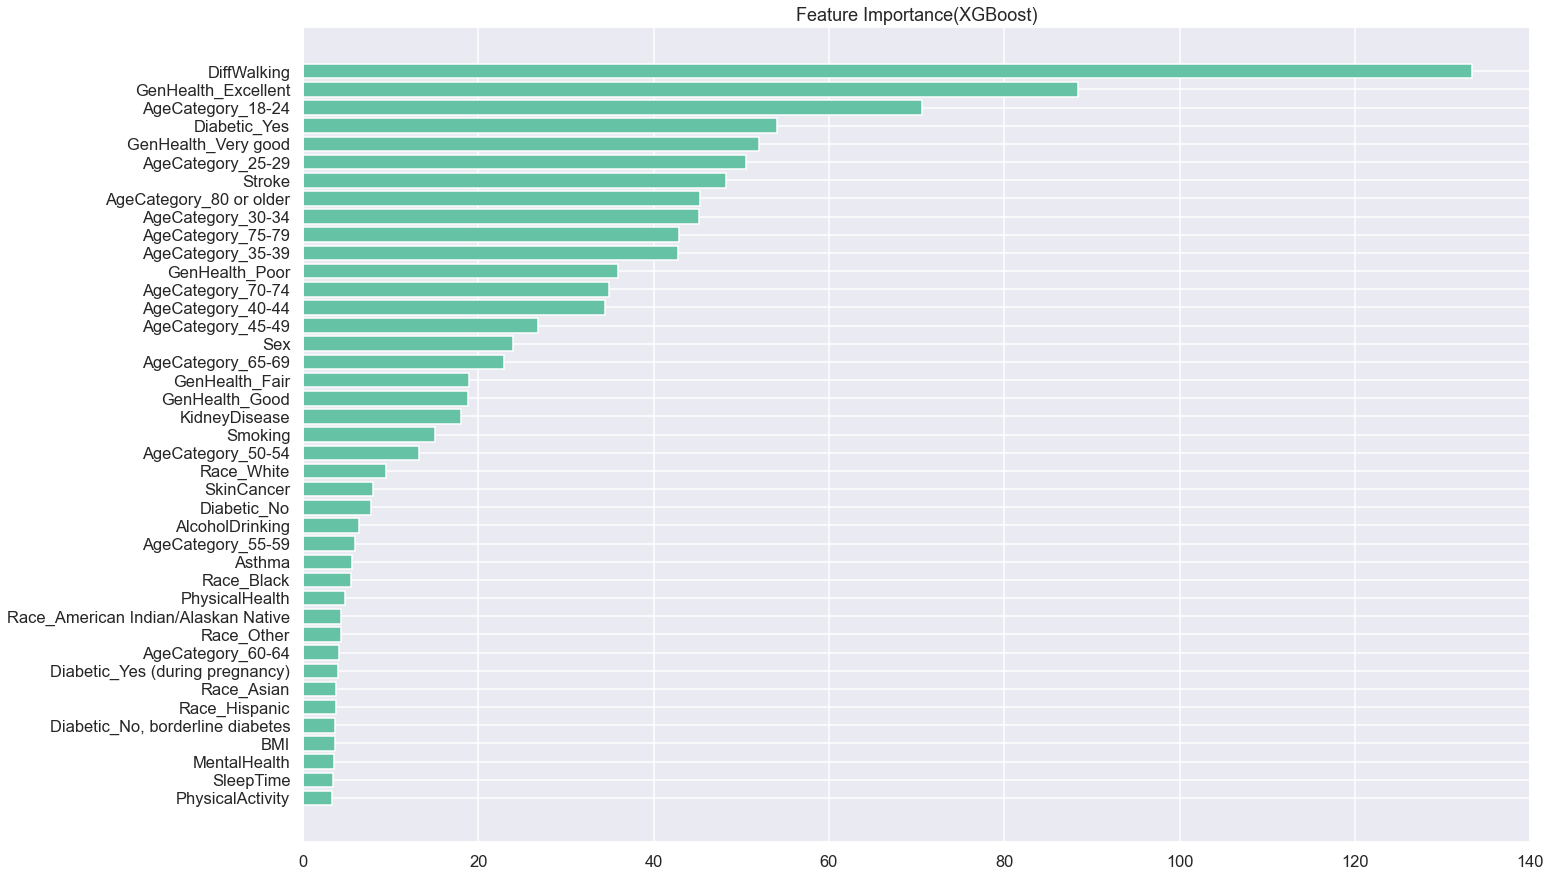

In [100]:
plt.barh(features, gains)
plt.title('Feature Importance(XGBoost)')
plt.gcf().set_size_inches(22, 15)
plt.show()

## ROC Curves

In [101]:
log_fpr, log_tpr, _ = metrics.roc_curve(y_test,  y_pred_proba[::,1])
rfc_fpr, rfc_tpr, _ = metrics.roc_curve(y_test,  y_rfc_pred_proba[::,1])
xgbc_fpr, xgbc_tpr, _ = metrics.roc_curve(y_test,  y_xbgc_pred_proba[::,1])

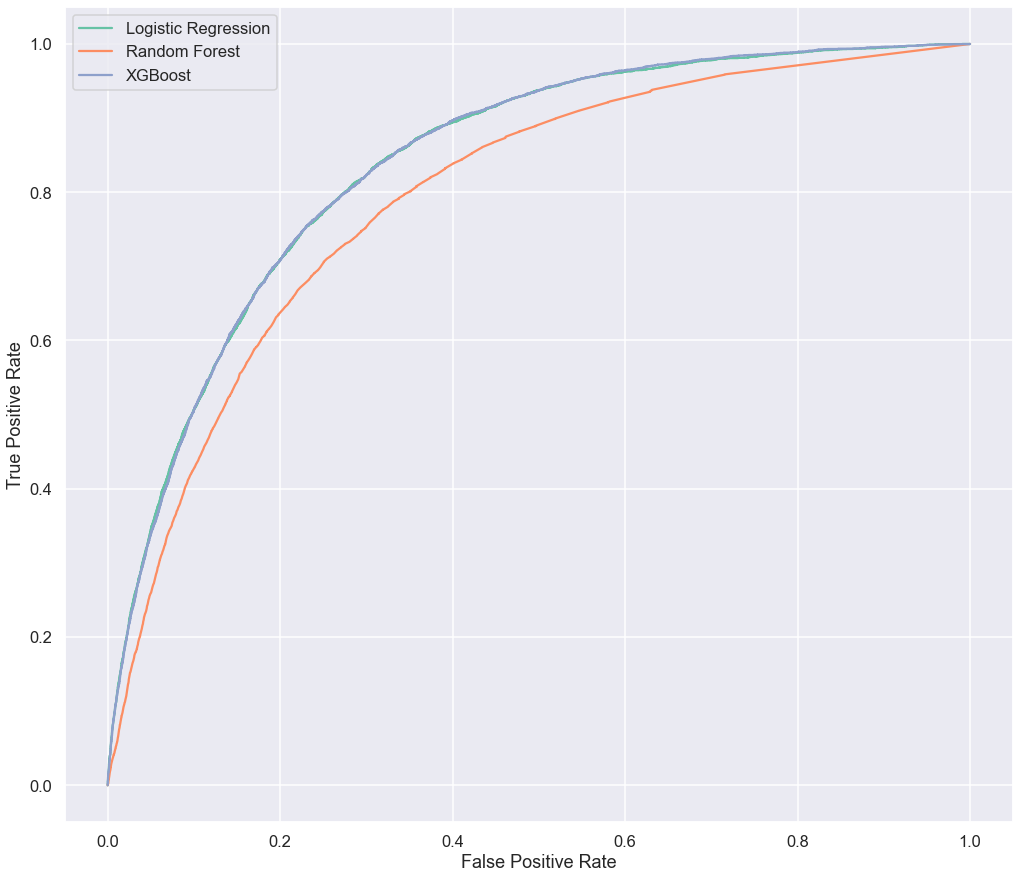

In [102]:
plt.plot(log_fpr, log_tpr, label = 'Logistic Regression')
plt.plot(rfc_fpr, rfc_tpr, label = 'Random Forest')
plt.plot(xgbc_fpr, xgbc_tpr, label = 'XGBoost')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.gcf().set_size_inches(17, 15)
plt.show()

In [103]:
# Testing the specific threshold of .15
threshold = 0.15
preds_biased = np.where(y_xbgc_pred_proba[:,1] > threshold, 1, 0)

In [104]:
print('accuracy_score: ', metrics.accuracy_score(y_test, preds_biased))
print('f1_score: ', metrics.f1_score(y_test, preds_biased))
print('recall_score: ', metrics.recall_score(y_test, preds_biased))
print('precision_score: ', metrics.precision_score(y_test, preds_biased))
print('confusion_matrix :\n ', metrics.confusion_matrix(y_test, preds_biased))

accuracy_score:  0.8308447599243265
f1_score:  0.3857378073014251
recall_score:  0.6236460436937764
precision_score:  0.2792207792207792
confusion_matrix :
  [[49743  8769]
 [ 2050  3397]]


In [105]:
threshold_list = np.linspace(0, 1, num=100)

In [106]:
# Making dataframe where each row gives the threshold and the recall and accuracy given that threshold 
threshold_list = []
for thresh in np.linspace(0, 1, num=100):
    preds_biased = np.where(y_xbgc_pred_proba[:,1] > thresh, 1, 0)
    recall = metrics.recall_score(y_test, preds_biased)
    accuracy = metrics.accuracy_score(y_test, preds_biased)
    threshold_list.append((thresh, recall, accuracy))
threshold_df = pd.DataFrame(threshold_list, columns=['Threshold','Recall','Accuracy'])

In [107]:
threshold_df

,Threshold,Recall,Accuracy
0,0.000000,1.000000,0.085164
1,0.010101,0.981274,0.348223
2,0.020202,0.958326,0.475289
3,0.030303,0.933725,0.545803
4,0.040404,0.908390,0.601323
...,...,...,...
95,0.959596,0.000000,0.914836
96,0.969697,0.000000,0.914836
97,0.979798,0.000000,0.914836
98,0.989899,0.000000,0.914836


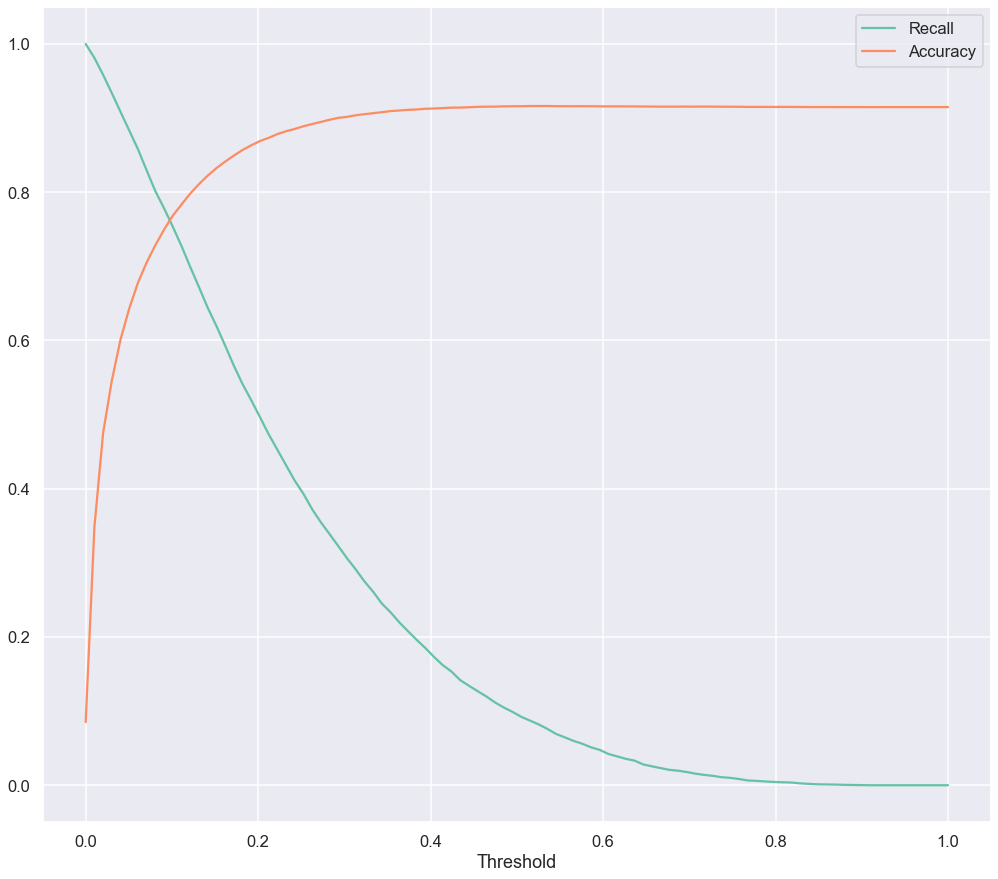

In [108]:
plt.plot(threshold_df['Threshold'], threshold_df['Recall'], label = 'Recall')
plt.plot(threshold_df['Threshold'], threshold_df['Accuracy'], label = 'Accuracy')
plt.xlabel('Threshold')
plt.legend()
plt.gcf().set_size_inches(17, 15)
plt.show()